In [1]:
import joblib
import pandas as pd
import numpy as np
from config import RANDOM_SEED
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

X_train = joblib.load('../processed/X_train_scaled.pkl')
X_test = joblib.load('../processed/X_test_scaled.pkl')
y_train = joblib.load('../processed/y_train.pkl')
y_test = joblib.load('../processed/y_test.pkl')

#FIX: feat_names for each loaded data
feat_names = [f'feat_{i}' for i in range(X_train.shape[1])]
print(f"Features: {X_train.shape}")

#DataFrames for features
X_train_df = pd.DataFrame(X_train, columns=feat_names)
X_test_df = pd.DataFrame(X_test, columns=feat_names)


Features: (175341, 43)


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#baseline without new features to test
lr_baseline = LogisticRegression(penalty='l2', max_iter=1000, random_state=RANDOM_SEED)
lr_baseline.fit(X_train, y_train)
y_pred_base = lr_baseline.predict(X_test)
f1_base = f1_score(y_test, y_pred_base, average='weighted')

print(f"F1 BASELINE without new features: {f1_base:.4f}")

c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


F1 BASELINE without new features: 0.6473


In [3]:
X_train_enh = X_train_df.copy()
X_test_enh = X_test_df.copy()

n_cols = X_train_enh.shape[1]

#Total_bytes
X_train_enh['total_bytes'] = X_train_enh.iloc[:, 0] + X_train_enh.iloc[:, 1]
X_test_enh['total_bytes'] = X_test_enh.iloc[:, 0] + X_test_enh.iloc[:, 1]

#Ratios
X_train_enh['ratio_01'] = X_train_enh.iloc[:, 0] / (X_train_enh.iloc[:, 1] + 1) #+1 to not divide /0
X_test_enh['ratio_01'] = X_test_enh.iloc[:, 0] / (X_test_enh.iloc[:, 1] + 1)

#Average per unit
X_train_enh['avg_per_unit'] = (X_train_enh.iloc[:, 0:2].sum(axis=1)) / (X_train_enh.iloc[:, 2:4].sum(axis=1) + 1)
X_test_enh['avg_per_unit'] = (X_test_enh.iloc[:, 0:2].sum(axis=1)) / (X_test_enh.iloc[:, 2:4].sum(axis=1) + 1)

#Rate
X_train_enh['rate_feature'] = X_train_enh.iloc[:, 0:3].sum(axis=1) / (X_train_enh.iloc[:, 3:6].sum(axis=1) + 0.001)
X_test_enh['rate_feature'] = X_test_enh.iloc[:, 0:3].sum(axis=1) / (X_test_enh.iloc[:, 3:6].sum(axis=1) + 0.001)

# VERIFICACIÓN SIMPLE (sin list comprehension problemática)
nuevas_cols = ['total_bytes', 'ratio_01', 'avg_per_unit', 'rate_feature']
print("New features:", nuevas_cols)
print(f"Shape before: {X_train_df.shape}")
print(f"Shape after: {X_train_enh.shape}")
print(f"Total columns: {len(X_train_enh.columns)}")



New features: ['total_bytes', 'ratio_01', 'avg_per_unit', 'rate_feature']
Shape before: (175341, 43)
Shape after: (175341, 47)
Total columns: 47


In [4]:
#FIX: Columns into string
X_train_enh.columns = X_train_enh.columns.astype(str)
X_test_enh.columns = X_test_enh.columns.astype(str)

#scaling enhanced 
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

lr_enh = LogisticRegression(random_state=42, max_iter=2000)
lr_enh.fit(X_train_enh_scaled, y_train)
y_pred_enh = lr_enh.predict(X_test_enh_scaled)
f1_enh = f1_score(y_test, y_pred_enh, average='weighted')

print("\n FEATURE ENGINEERING:")
print(f"F1 BASE:     {f1_base:.4f}")
print(f"F1 ENHANCED: {f1_enh:.4f}")
print(f"GAIN:        {((f1_enh-f1_base)/f1_base*100):+.1f}%") #less than before +features -f1_score
print(classification_report(y_test, y_pred_enh))



 FEATURE ENGINEERING:
F1 BASE:     0.6473
F1 ENHANCED: 0.6450
GAIN:        -0.4%
              precision    recall  f1-score   support

           0       0.59      0.66      0.62     37000
           1       0.69      0.63      0.66     45332

    accuracy                           0.64     82332
   macro avg       0.64      0.65      0.64     82332
weighted avg       0.65      0.64      0.65     82332



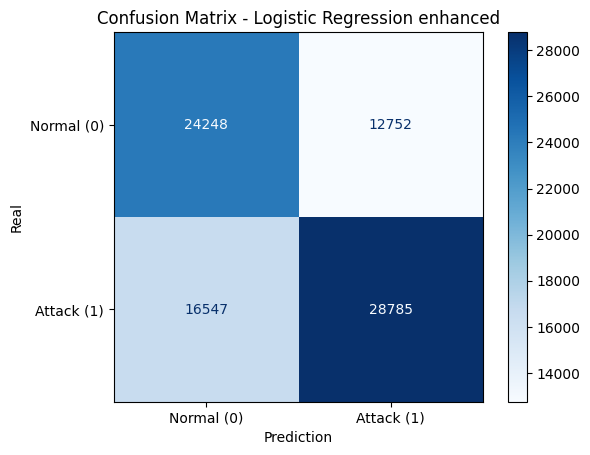

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_preds = {
    "Logistic Regression enhanced": y_pred_enh,
}

for name, y_pred in model_preds.items():
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Attack (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Prediction")
    plt.ylabel("Real")
    plt.show()

#TN 24271 -> 24248
#FP 12729 -> 12752
#FN 16381 -> 16547
#TP 28951 -> 28785 

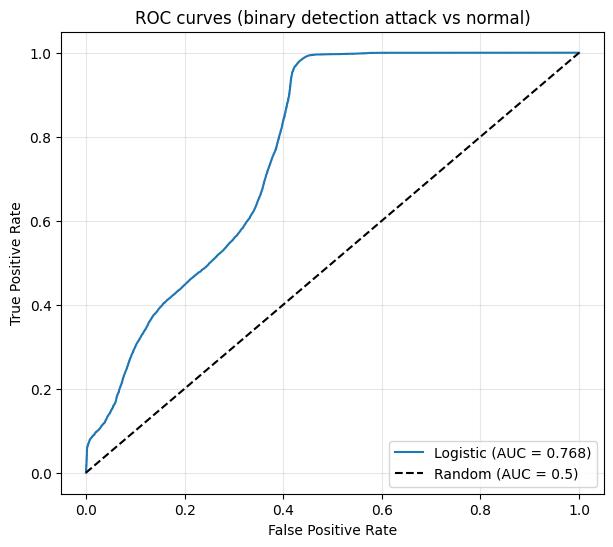

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(7, 6))

# Logistic
y_score_lr = lr_enh.predict_proba(X_test_enh_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
auc_lr = roc_auc_score(y_test, y_score_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC = {auc_lr:.3f})")

# Diagonal azar
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (binary detection attack vs normal)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
#0.771 -> 0.768

In [7]:
from sklearn.decomposition import PCA

# adding PCA 95% of variency
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train_enh) # Usar datos escalados
X_test_pca = pca.transform(X_test_enh)

print(f"Original components: {X_train.shape[1]}")
print(f"Components after PCA: {X_train_pca.shape[1]}")

lr_pca = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr_pca.fit(X_train_pca, y_train)


y_pred_pca = lr_pca.predict(X_test_pca)
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')

print(f"F1 Score with PCA: {f1_pca:.4f}")

Original components: 43
Components after PCA: 3
F1 Score with PCA: 0.6194


In [8]:
import joblib
joblib.dump(X_train_enh, 'processed/X_train_enhanced.pkl')
joblib.dump(X_test_enh, 'processed/X_test_enhanced.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'processed/X_train_enhanced.pkl'